# Relatório EP2 - Programação Concorrente e Paralela
***

**Alunos**: 
- Erick Rodrigues de Santana, NUSP: 11222008
- Francisco Eugênio Wernke, NUSP: 11221870
- Thiago Guerrero Balera, NUSP: 11275297
- Vinicius Pereira Ximenes Frota, NUSP: 11221967

**Professor**: Alfredo Goldman

**Monitores**: Elisa Silva e Luciana Marques

O relatório a seguir foi elaborado com base nas instruções do EP2 da Matéria MAC0219 - Programação Concorrente e Paralela.

## Objetivos
***

* Analisar o impacto no uso da biblioteca OpenMPI para paralelização de programas usando processos;
* Analisar a integração entre a biblioteca OpenMPI e as bibliotecas de criação de threads Pthreads e OpenMP;
* Analisar o tradeoff entre uso de threads e processos;
* Estimar os melhores parâmetros de número de processos e threads para o programa especificado;
* Comparar as diferentes versões multithreads do EP1 e do EP2.

## Introdução
***

O principal objetivo desse exercício-programa é analisar a utilização da biblioteca OpenMPI para o cálculo do conjunto de Mandelbrot em uma região específica.

Na primeira parte vamos analisar o desempenho de uma paralização somente com processos, ou seja, utilizando somente a biblioteca OpenMPI. Em seguida, vamos analisar como uma paralização usando, em conjunto, processos e threads se comporta, utilizando também as bibliotecas de criação de thread Pthread e OpenMP.

Nesta análise iremos estimar os melhores parâmetros dentro de uma região de interesse que será especificada mais adiante. Esses parâmetros são:
* Número de processos, para a versão usando puramente OpenMPI;
* Número de processos e threads, para as versões com a paralelização mista.

Já na segunda parte, vamos utilizar os melhores parâmetros encontrados na primeira parte e comparar o desempenho entre todas as versões multithreads, ou seja, todas as versões desenvolvidas nesse EP e as versões do EP1.

## Metodologia
***

Nesta seção vamos apresentar algumas decisões de projeto.

### Conjunto de Mandelbrot
Como especificado pelo enunciado, os experimentos serão feitos usando um tamanho de imagem de 4096 na região *Triple Spiral Valley*.


### Regiões de interesse
Para a realização dos experimentos escolhemos as seguintes regiões de interesse para a análise:
* **Processos:** $[2^0, ..., 2^4]$
* **Threads:** $[2^0, ..., 2^5]$

A escolha dessas regiões levou em conta a capacidade computacional da rede Linux com o intuito de não monopolizar todo o poder computacional para o nosso grupo.

### Poder computacional

Para rodar todos os experimentos, utilizamos a máquina *Neozil* da rede Linux. Essa máquina possui 32 cores e 62.8GB de memória RAM.

### Executando o programa
Para executar o programa *mandelbrot* nas versões com OpenMPI (Sequencial, OpenMP e Pthreads), adicionamos um argumento extra para definir o número de processos a serem criados (num_processes). Além disto, nas versões internamente paralelizadas, ainda existe o argumento de quantas threads serão criadas (num_threads). Antes de executar os comandos, é necessário gerar os binários desta forma:

```bash
cd src
make
```

Agora, pode-se executar as três formas do *mandelbrot* com OpenMPI da seguinte forma:

```bash
mpirun -np <num_processes> mandelbrot_mpi
mpirun -np <num_processes> mandelbrot_mpi_omp <num_threads>
mpirun -np <num_processes> mandelbrot_mpi_pth <num_threads>
```

Já para as versões do EP1:

```bash
./mandelbrot_seq
./mandelbrot_omp <num_threads>
./mandelbrot_pth <num_threads>
```

## Paralelização
***

Nesta seção iremos apresentar qual foi a estratégia de paralelização adotada.

### Visão geral
Todas as versões possuem uma função chamada *mpi_managment* que é responsável por gerenciar toda a sincronização da biblioteca OpenMPI. A função é responsável por separar a imagem em blocos, definindo o valor de *i_y* para cada processo, chamar a função *compute_mandelbrot* e, por fim, sincronizar todos os dados no processo *Host*.

### Sincronização dos dados
Para esta etapa, optamos por usar a função *MPI_Gather* oferecida pela biblioteca OpenMPI. Essa função reune dados de vários processos diferentes e junta todos eles em um único processo usando o *rank* de cada processo como forma de ordenação. A imagem abaixo ilustra o funcionamento dessa função:

![gather](https://mpitutorial.com/tutorials/mpi-scatter-gather-and-allgather/gather.png)

Nossa estratégia foi reunir todos os dados de iteração de cada píxel no processo *Host*. Para isso, cada processo processa um bloco de pixels, armazenando somente o número de iterações (e não mais o código RGB) e, após o processamento, manda esses dados para o processo *Host*, que é o responsável por montar a imagem final.

Armazenar somente o número de iterações ajuda na otimização de memória e também na otimização do uso da biblioteca OpenMPI.

### Estrutura do programa OpenMPI puro
Para essa versão, calculamos o valor do *chunk* de cada processo como

*chunk = i_y_max/num_processes*

E *i_y* como

*i_y = chunk\*process_rank*

Após isto, cada processo calcula todos os pixels no intervalo \[ i_y, i_y+chunk [

### Estrutura dos programas OpenMPI+Pthreads e OpenMPI+OpenMP
Estas versões definem o *i_y* da mesma forma, entretanto, o processamento do intervalo \[ i_y, i_y+chunk [ é separado entre as threads, implementando uma ideia similar a base e limite.


## Descrição geral dos experimentos
***

### Geração dos dados
Para a geração dos *.csv*, utilizamos alguns scripts em Bash que podem ser encontrados no nosso [repositório](https://github.com/T-Guerrero/MAC0219-EP2).

### Medições

Foram feitas 15 medições.

### Tempo observado
O tempo coletado nos experimentos foi somente do período de processamento, ou seja, somente do período de execução da função *mpi_managment*.

### Intervalo de confiança

Para 95% de nível de confiança e n-1 (14) graus de liberdade, obtemos pela tabela da t-student o valor 2.1448 para z. O código abaixo implementa uma função que retorna somente os limiares:


In [58]:
'''
Recebe um vetor de dados e a média desses dados.
Retorna os limiares do intervalo de confiança.
'''
def confidence_interval(vector, mean):
    z = 2.1448
    n = len(vector)
    sigma = 0
    for i in vector:
        sigma += (i - mean)**2;

    sigma /= n-1;
    sigma = sqrt(sigma);
    return z * sigma/sqrt(n);

## Experimentos
***

Bibliotecas importadas:

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

### Parte 1 - Estimativa dos melhores parâmetros

Sumário:
* [Organização dos dados](#first)
* [MPI - Visualização dos resultados](#second)
* [MPI - Discussão dos resultados](#third)
* [MPI Multithreads - Visualização dos resultados](#fourth)
* [MPI Multithreads - Discussão dos resultados](#fifth)

O arquivo *data.csv* gerado por um dos scripts tem a estrutura apresentada abaixo. 

In [60]:
csv = pd.read_csv("../measurements/data.csv")
print(csv)

        tipo  processos  threads         tempo
0        mpi          1        1  24237.120152
1        mpi          1        1  24395.095348
2        mpi          1        1  24355.067730
3        mpi          1        1  24333.413601
4        mpi          1        1  24350.424290
..       ...        ...      ...           ...
970  mpi_omp         16       32   1168.375492
971  mpi_omp         16       32   1420.077801
972  mpi_omp         16       32   1414.572239
973  mpi_omp         16       32   1179.508924
974  mpi_omp         16       32   1176.087618

[975 rows x 4 columns]


#### Organização dos dados <a id="first"></a>

Para agrupar os dados coletados usamos a estrutura de dados de dicionário. A estrutura pode ser entendida assim:
```json
{
    mpi: [
        2^0 processo: Pair<Média, Intervalo de confiança>,
        2^1 processos: Pair<Média, Intervalo de confiança>,
        ...
        2^4 processos: Pair<Média, Intervalo de confiança>
    ],
    mpi_pth: {
        2^0 thread: [
            2^0 processo: Pair<Média, Intervalo de confiança>,
            2^1 processos: Pair<Média, Intervalo de confiança>,
            2^2 processos: Pair<Média, Intervalo de confiança>,
            ...
            2^4 processos: Pair<Média, Intervalo de confiança>
        ],
        2^1 threads: [
            ...Mesmo que para 1 thread
        ],
        ...
        2^5 threads: [
            ...Mesmo que para 1 thread
        ],
    },
    mpi_omp: { ...Mesmo que mpi_pth }
}
```

Como o intervalo de confiança é simétrico em torno da média, só armazenamos os limiares.

In [61]:
'''
Definição das estruturas de dados
'''
data = {"mpi" : [], "mpi_pth" : dict(), "mpi_omp" : dict()}
tipos = ["mpi", "mpi_pth", "mpi_omp"]

Assim, podemos processar as 15 medições e armazenar a média e o intervalo de confiança nas estruturas de dados:

In [62]:
'''
Processamento dos dados
'''
threads = [2**i for i in range(6)]

'''
MPI Puro
'''
for i in range(5):
    vector = csv["tempo"][i*15:(i+1)*15]
    mean = sum(vector)/15
    pair = (mean, confidence_interval(vector, mean))
    data["mpi"].append(pair)

'''
MPI+Pthreads
MPI+OpenMP
'''
for tipo in tipos[1:]:
    for thread in threads:
        data[tipo][thread] = []
        
        filtered = csv[csv["tipo"] == tipo]
        filtered = filtered[filtered["threads"] == thread]
        filtered = list(filtered["tempo"])
        for i in range(5):
            vector = filtered[i*15:(i+1)*15]
            mean = sum(vector)/15
            pair = (mean, confidence_interval(vector, mean))
            data[tipo][thread].append(pair)

A função auxiliar abaixo será usada para exibir os dados nas próximas seções:

In [88]:
'''
Recebe os valores a serem printados.
Printa os valores numa tabela.
'''
def data_print(values):
    print ("{:^10} {:^20} {:^30}".format("Processos", "Tempo" , "Limiar do intervalo de confiança"))
    for idx, value in enumerate(values):
        mean, confidence_interval = value
        print ("{:^10} {:^20} {:^30}".format(2**idx, mean, confidence_interval))

### MPI - Visualização dos resultados <a id="second"></a>

Para visualizar os resultados, plotamos um gráfico que possui o número de processos dos experimentos em função do seu tempo de processamento, em milissegundo.

Por motivos de melhor visualização dos resultados, optamos por exibir o eixo y em escala logarítimica com base 2.

In [63]:
'''
Definição do eixo x
'''
x = [2**i for i in range(5)]

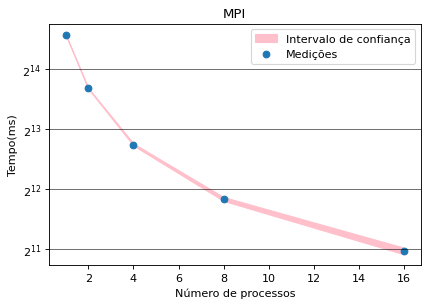

Processos         Tempo         Limiar do intervalo de confiança
    1       24340.326674733333        74.62604191774881       
    2       13094.284884066667        70.34995500144774       
    4       6841.701110133333         82.62360100746305       
    8       3642.6725706666666        81.44316272438556       
    16      1995.2112674666666         75.7045419957342       


In [94]:
'''
Coleta dos dados necessários para o plot do MPI
'''
y_mpi = [i[0] for i in data["mpi"]]
y_mpi = np.array(y_mpi)

confidence_mpi = [i[1] for i in data["mpi"]]
confidence_mpi = np.array(confidence_mpi)

'''
Plot
'''
plt.figure(figsize=(6, 4), dpi=80)
plt.fill_between(x, (y_mpi-confidence_mpi), (y_mpi+confidence_mpi), color='pink', alpha=1)
plt.scatter(x, y_mpi)

plt.grid(color='black', linewidth=0.5, axis = 'y')

plt.title("MPI")
plt.xlabel("Número de processos")
plt.ylabel("Tempo(ms)")
plt.legend(["Intervalo de confiança", "Medições"])

plt.yscale("log", base = 2)
plt.show()

'''
Print dos valores
'''
data_print(data['mpi'])

### MPI - Discussão dos resultados <a id="third"></a>

Podemos notar de imediato que há uma melhora conforme aumenta o número de processos. Entretanto, é possível visualizar que a taxa de redução do tempo é cada vez menor. Uma hipótese é de que o custo de criação dos processos começa supera o ganho no uso dos mesmos.

Porém, conseguimos ver que o ganho de desempenho foi muito grande, reduzindo cerca de 22s quando comparamos a versão sequencial (1 processo) e a versão com 16 processos. 

Escolhemos como melhor parâmetro o uso de 16 processos.

### MPI Multithreads - Visualização dos resultados <a id="fourth"></a>


Para visualizar os resultados, plotamos um gráfico para cada tamanho de thread comparando os diferentes números de processos em cada uma das versões.

Por motivos de melhor visualização dos resultados, optamos por exibir o eixo y em escala logarítimica com base 2.

In [49]:
'''
Definição do eixo x
'''
x = [2**i for i in range(5)]

A função abaixo recebe o número de threads e plota uma comparação entre as versões OpenMPI+Pthreads e OpenMPI+OpenMP

In [103]:
'''
Recebe um número de thread.
Coleta os dados para o número fornecido
e plota o gráfico de cada versão.
'''
def plot(threads):
    y = []
    confidence = []
    
    y_mpi_pth = [i[0] for i in data["mpi_pth"][threads]]
    y.append(np.array(y_mpi_pth))

    y_mpi_omp = [i[0] for i in data["mpi_omp"][threads]]
    y.append(np.array(y_mpi_omp))
    
    confidence_mpi_pth = [i[1] for i in data["mpi_pth"][threads]]
    confidence.append(np.array(confidence_mpi_pth))

    confidence_mpi_omp = [i[1] for i in data["mpi_omp"][threads]]
    confidence.append(np.array(confidence_mpi_omp))

    fig, axs = plt.subplots(1, 2, figsize = (12, 4), dpi=80)
    titles = ["MPI Pthreads", "MPI OpenMP"]
    for i, title in enumerate(titles):
        axs[i].fill_between(x, (y[i]-confidence[i]), (y[i]+confidence[i]), color='pink', alpha=1)
        axs[i].scatter(x, y[i])
        axs[i].grid(color='black', linewidth=0.5, axis = 'y')
        axs[i].set_yscale("log", base = 2)
        axs[i].set(ylabel = "Tempo(ms)" , xlabel = "Número de processos")
        axs[i].set_title(title)
        axs[i].legend(["Intervalo de confiança", "Medições"])
        fig.suptitle(str(threads) + " thread(s)")
    plt.show()
    '''
    Print dos valores
    '''
    print("{:^60}".format("Pthreads"))
    data_print(data['mpi_pth'][threads])
    print("\n")
    print("{:^60}".format("OpenMP"))
    data_print(data['mpi_omp'][threads])

Utilizando a função para os valores definidos:

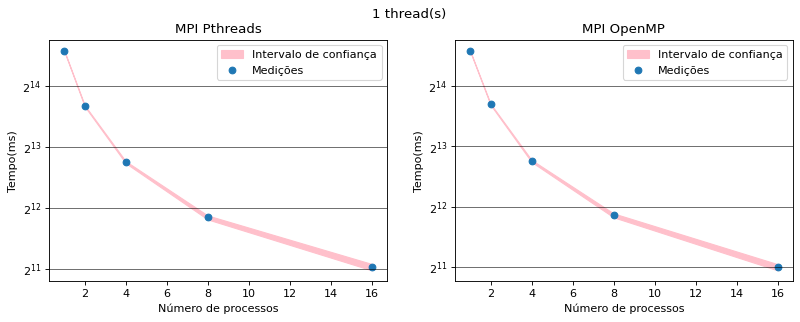

                          Pthreads                          
Processos         Tempo         Limiar do intervalo de confiança
    1       24348.083607266668        75.55687711742361       
    2       13026.887925466668        82.91086932891363       
    4          6876.0444322           77.66861966519785       
    8       3671.4347998666663        82.15912998171454       
    16      2089.476156333333         75.59466282954124       


                           OpenMP                           
Processos         Tempo         Limiar do intervalo de confiança
    1          24558.968242           75.68246562109115       
    2       13275.480381666664        84.76994264756242       
    4       6919.889116266668         80.14724043611893       
    8       3700.9473324666665        83.19943715785743       
    16      2037.7666792000002        72.25400900993242       


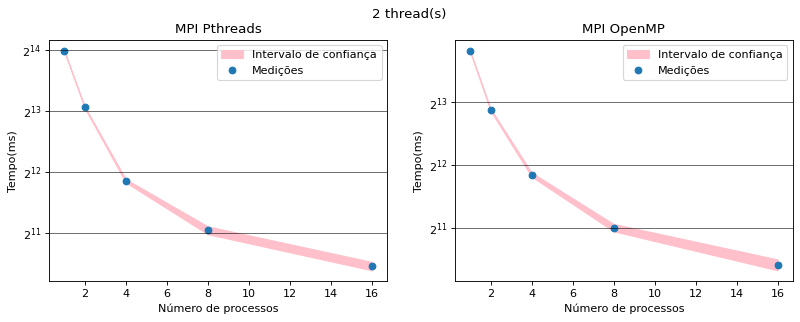

                          Pthreads                          
Processos         Tempo         Limiar do intervalo de confiança
    1         16151.4556568            83.0896209821448       
    2       8527.199252466668         81.76203936024427       
    4          3702.7171612           69.06500455247945       
    8       2113.564459466667         93.30767875089816       
    16      1407.1128208666667         66.9709474311023       


                           OpenMP                           
Processos         Tempo         Limiar do intervalo de confiança
    1       14383.195559266664         85.9346591774266       
    2       7544.725736066668         86.41058320672417       
    4       3689.438994733334         81.93591883022927       
    8       2056.680806533333          82.6585600723781       
    16      1364.8364384666668        81.67521495261722       


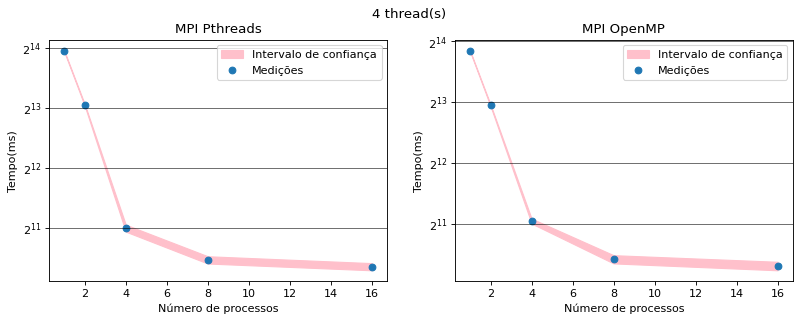

                          Pthreads                          
Processos         Tempo         Limiar do intervalo de confiança
    1       15695.39265626667         105.42695854439043      
    2       8428.322060800001         86.65056504731804       
    4          2036.5857918           81.91292538976612       
    8          1411.9818052           59.451005295984274      
    16      1305.0003370000002         54.0790383332224       


                           OpenMP                           
Processos         Tempo         Limiar do intervalo de confiança
    1       14634.986988799998        79.22411426275279       
    2       7887.837378266667         76.56913448096796       
    4       2117.2830105333333        59.236182191075955      
    8          1371.4376132           64.26978463971028       
    16      1270.393069466667         61.67477080289395       


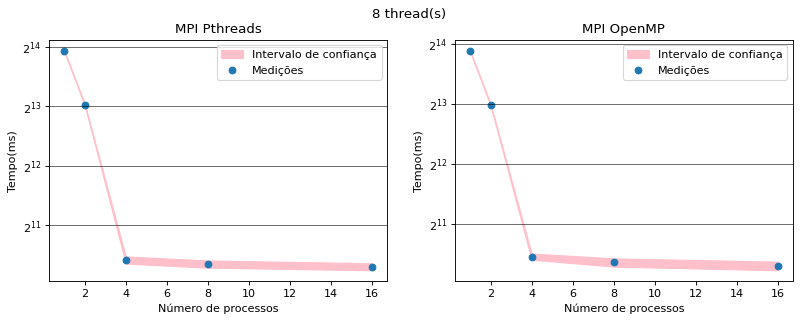

                          Pthreads                          
Processos         Tempo         Limiar do intervalo de confiança
    1       15605.376656666665        96.15638124431102       
    2       8367.128753666668         85.89284605066572       
    4       1369.5397853333336         57.522759797702        
    8       1306.0353913999998        54.923773443100345      
    16      1265.5215739999999         52.0955416944683       


                           OpenMP                           
Processos         Tempo         Limiar do intervalo de confiança
    1       15041.237258866668        81.98738952360316       
    2       8100.627470133333         88.44728505470006       
    4       1400.5311012666668        49.789133090714046      
    8          1309.0839068           62.32680979240754       
    16      1257.3587099333336        62.74588322499792       


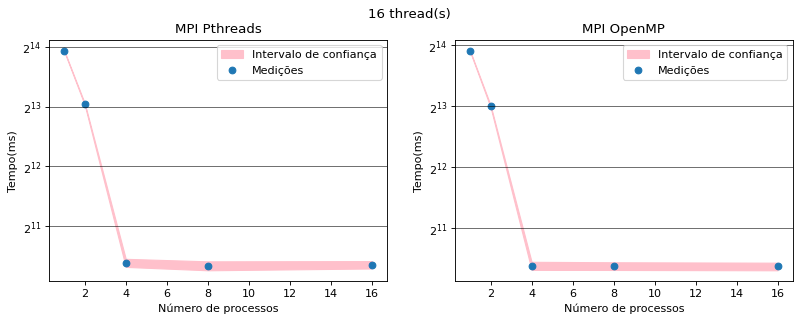

                          Pthreads                          
Processos         Tempo         Limiar do intervalo de confiança
    1       15590.817260800004        78.71013986120725       
    2       8429.708035866666         85.69429238172097       
    4       1342.9332732666664        62.924147627474404      
    8       1297.9224205333335        67.22984424981455       
    16         1313.1147862           56.31798141071138       


                           OpenMP                           
Processos         Tempo         Limiar do intervalo de confiança
    1       15356.223265333334        88.59413560239219       
    2       8208.767922666668         99.22970072905063       
    4       1338.8412951333332        61.68333295993986       
    8          1334.6867562           58.48871595492889       
    16         1328.9274058           57.48578820472554       


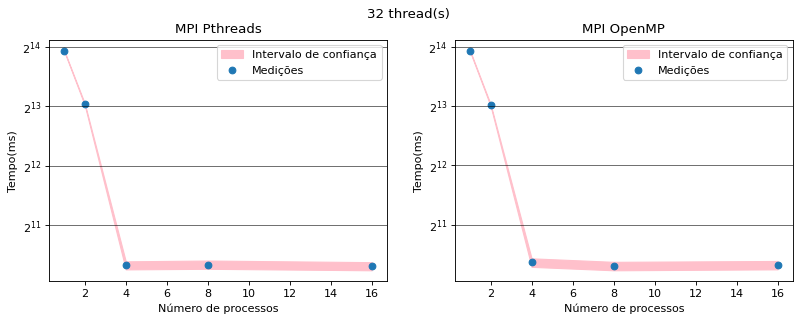

                          Pthreads                          
Processos         Tempo         Limiar do intervalo de confiança
    1       15583.383464800001        73.27152111698403       
    2       8384.241580933332         86.70570115372348       
    4       1288.3229574000002        60.53769578130375       
    8       1298.7768172000003        62.42755760748592       
    16         1275.5383016           60.393118902503666      


                           OpenMP                           
Processos         Tempo         Limiar do intervalo de confiança
    1       15518.901824800001        98.60294762461363       
    2       8284.359439133334         85.89413086020737       
    4       1321.179723733333         65.65705660909046       
    8       1268.7271436666667        62.53481346305228       
    16      1282.2607040000003        62.60432717681288       


In [104]:
for i in range(6):
    plot(2**i)

### MPI Multithreads - Discussão dos resultados <a id="fifth"></a>

É evidente que, em geral, todos os gráficos apresentam uma redução no tempo com o aumento do número de processos, mesmo que este aumento não seja constante. Isso nos leva a crer que a paralelização usando processos e threads em conjunto pode ser uma alternativa.

Analisando o caso com 2 threads e 8 processos, não atingimos o mesmo potencial que a versão usando somente MPI com 16 processos, mesmo tendo 16 threads executando (8\*2 = 16). O mesmo ocorre com 4 threads e 4 processos. Disso podemos concluir que o custo da criação dos processos somado com o custo de criação das 16 threads ultrapassa o custo de criação de somente 16 processos que ocorre na versão MPI. Entretanto, perceba que não podemos falar o mesmo para o caso de 8 threads e 2 processos.

Conforme aumenta o número de threads, é possível notar que o valor mínimo observado no tempo é alcançado cada vez mais cedo, ou seja, menos processos são necessários para atingir este valor.

É possível notar também que existe um limitante para a otimização de tempo do programa. Logo, como consequência do item anterior, após atingir esse limitante, não existe uma melhoria significativa com o aumento do número de processos.

Analisando os gráficos e considerando os custos envolvidos em comparação com os benefícios, concluimos que os valores mais adequados são 8 threads e 4 processos ou 4 threads e 8 processos. Entretanto, escolhemos como melhores parâmetros o uso de 8 threads e 4 processos, pois conseguimos ver que essa coleção de parâmetros apresenta um tempo um pouco menor, já que o custo de criação de processos é muito maior do que o de criação de threads.

### Parte 2 - Comparação entre as versões

Sumário:
* [Organização dos dados](#fourth)
* [Visualização dos resultados](#fifth)
* [Discussão dos resultados](#sixth)

In [52]:
# Leitura de dados CSV
csv = pd.read_csv("../measurements/comparison.csv")
print(csv)

       tipo  processos  threads         tempo
0       seq          1        1  24505.006790
1       seq          1        1  24580.294132
2       seq          1        1  24475.879431
3       seq          1        1  24451.589108
4       seq          1        1  24449.499607
..      ...        ...      ...           ...
85  mpi_omp          4        8   1288.047075
86  mpi_omp          4        8   1485.781431
87  mpi_omp          4        8   1229.299307
88  mpi_omp          4        8   1194.517851
89  mpi_omp          4        8   1279.103994

[90 rows x 4 columns]


#### Organização dos dados <a id="fourth"></a>


Para agrupar os dados coletados usamos a estrutura de dados de dicionário. A estrutura pode ser entendida assim:
```json
{
    seq: Pair<Média, Intervalo de confiança>,
    pth: Pair<Média, Intervalo de confiança>,
    opm: Pair<Média, Intervalo de confiança>,
    mpi: Pair<Média, Intervalo de confiança>,
    pth_mpi: Pair<Média, Intervalo de confiança>,
    omp_mpi: Pair<Média, Intervalo de confiança>,
}
```

Como o intervalo de confiança é simétrico em torno da média, só armazenamos os limiares.

In [53]:
'''
Definição das estruturas de dados
'''
data = {"seq": (0,0), "pth" : (0,0), "omp" : (0,0), "mpi" : (0,0), "mpi_pth" : (0,0), "mpi_omp" : (0,0)}

threads = [2**i for i in range(6)]
tipos = ["seq", "pth", "omp", "mpi", "mpi_pth", "mpi_omp"]

In [54]:
'''
Processamento dos dados
'''
for i, tipo in enumerate(tipos):
    vector = csv["tempo"][i*15:(i+1)*15]
    mean = sum(vector)/15
    pair = (mean, confidence_interval(vector, mean))
    data[tipo] = pair

#### Visualização dos resultados <a id="fifth"></a>

Para visualizar os resultados, plotamos um gráfico de barra comparando as diferentes versões.

Por motivos de melhor visualização dos resultados, optamos por exibir o eixo y em escala logarítimica com base 2.

In [55]:
'''
Coleta dos valores
'''

y = []
confidence_interval = []

for tipo in tipos:
    y.append(data[tipo][0])
    confidence_interval.append(data[tipo][1])

In [56]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

xlabel = ['Seq', 'Pthreads \n 8 threads',
          'OMP \n 8 threads', 'MPI \n 16 processos',
          'MPI_Pthreads \n 4 processos \n 8 threads', 'MPI_OMP \n 4 processos \n 8 threads']

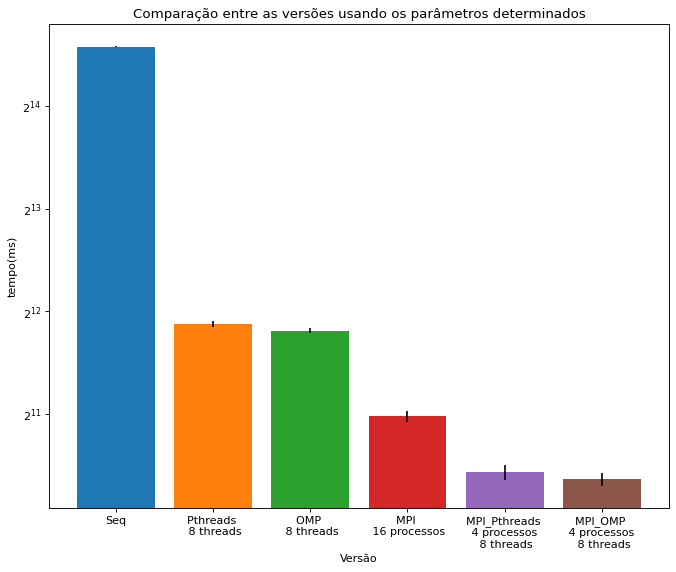

In [57]:
'''
Plota os resultados
'''
plt.figure(figsize=(10, 8), dpi=80)
plt.bar(range(len(tipos)), y, align='center', yerr=confidence_interval, color=colors)
plt.xticks(range(len(xlabel)), xlabel)
plt.yscale("log", base = 2)

plt.ylabel('tempo(ms)')
plt.xlabel('Versão')
plt.title('Comparação entre as versões usando os parâmetros determinados')
plt.show()

#### Discussão dos resultados <a id="sixth"></a>

* Mesmo que a criação de processos seja custosa, o uso de mais de um processo acaba fazendo uma paralelização benéfica.

* O uso de threads e processos produz um efeito similar. 
    * Como já sabemos, o overhead na criação de threads é menor em comparação com a criação de processos e, portanto, temos um overhead geral menor nessas versões.



### Conclusão
***

* É possível notar que as versões implementadas no EP2 possuem uma otimização similar em comparação com as do EP1.

* O uso da biblioteca MPI é bem consistente e otimizado.

* O uso em conjunto do MPI com as threads possui uma boa integração, levando a crer que o seu uso em uma rede de computadores será eficiente.

* Contudo, o uso do MPI em um único computador é menos eficiente do somente usar threads pois, como citado anteriormente, o overhead de criação de processos é maior.

* Desta forma, o uso de processos independentes promove escalabilidade do processamento em rede, o que não era possível somente com o uso de threads.